In [1]:
import pandas as pd
import scipy.io
import numpy as np
import scipy.sparse
import src.preprocessing.data_cleaning as data_cleaning
import src.preprocessing.normalization as normalization
import src.preprocessing.feature_selection as feature_selection
import src.preprocessing.dim_reduction as dim_reduction
import src.analysis.clustering as clustering
import src.analysis.cell_identification as cell_identification
import src.evaluation.evaluation as evaluation

metadata_path = "./data/PBMC/PBMC_68k/hg19/68k_pbmc_barcodes_annotation.tsv"
true_labels = evaluation.load_true_labels(metadata_path, "barcodes", "celltype", "\t")
print(true_labels.info())
print(true_labels.head())

def load_expression_data_from_mtx(path, barcodes_labeled=None, n_sample=None, random_state=None):
    """
    Load gene expression data from MTX format into a sparse DataFrame.

    Parameters:
    - path: str, path to the folder with the matrix, genes and barcodes.

    Returns:
    - expression_matrix: Sparse DataFrame containing gene expression data.
    """
    # Load expression matrix
    matrix = scipy.io.mmread(path+"matrix.mtx").tocsc()
    print("Matrix read")

    # Load genes
    genes = pd.read_csv(path+"genes.tsv", header=None, sep='\t', names=['gene_id', 'gene_symbol'])
    print("Genes read")

    # Load barcodes
    barcodes = pd.read_csv(path+"barcodes.tsv", header=None, sep='\t', names=['barcode'])
    print("Barcodes read")

    # Filter by labeled barcodes if barcodes_labeled is provided
    if barcodes_labeled is not None:
        if 'barcode' not in barcodes_labeled.columns:
            raise ValueError("The provided barcodes_labeled DataFrame must contain a 'barcode' column.")
        # Find the intersection of barcodes
        labeled_barcodes = set(barcodes_labeled['barcode'])
        matching_indices = barcodes['barcode'].isin(labeled_barcodes)
        matrix = matrix[:, matching_indices]
        barcodes = barcodes[matching_indices]

    # Apply random sampling to barcodes if n_sample is specified
    if n_sample is not None and n_sample < len(barcodes):
        np.random.seed(random_state)
        sampled_indices = np.random.choice(len(barcodes), size=n_sample, replace=False)
        matrix = matrix[:, sampled_indices]  # Subset columns (barcodes)
        barcodes = barcodes.iloc[sampled_indices]

    # Transform sparse matrix into pandas sparse DataFrame
    expression_matrix = pd.DataFrame.sparse.from_spmatrix(matrix)
    expression_matrix.index = genes['gene_symbol']
    expression_matrix.columns = barcodes['barcode']

    expression_matrix = data_cleaning.remove_duplicated_genes(expression_matrix)

    return expression_matrix

expression_matrix = load_expression_data_from_mtx("./data/PBMC/PBMC_68k/hg19/", barcodes_labeled=true_labels, n_sample=1000, random_state=6)

print(expression_matrix.info())

c:\users\34659\pycharmprojects\master_thesis\scrnaseq_across_human_tissues\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68579 entries, 0 to 68578
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   barcode     68579 non-null  object
 1   true_label  68579 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB
None
            barcode                    true_label
0  AAACATACACCCAA-1              CD8+ Cytotoxic T
1  AAACATACCCCTCA-1  CD8+/CD45RA+ Naive Cytotoxic
2  AAACATACCGGAGA-1           CD4+/CD45RO+ Memory
3  AAACATACTAACCG-1                       CD19+ B
4  AAACATACTCTTCA-1               CD4+/CD25 T Reg
Matrix read
Genes read
Barcodes read
<class 'pandas.core.frame.DataFrame'>
Index: 32643 entries, MIR1302-10 to ZNF84
Columns: 1000 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCCCT-8
dtypes: Sparse[float64, 0](1000)
memory usage: 6.4+ MB
None


In [2]:
duplicated_genes = expression_matrix.index[expression_matrix.index.duplicated()]
if len(duplicated_genes) > 0:
    print(f"Genes duplicados encontrados: {duplicated_genes}")

print(true_labels['true_label'].unique())

['CD8+ Cytotoxic T' 'CD8+/CD45RA+ Naive Cytotoxic' 'CD4+/CD45RO+ Memory'
 'CD19+ B' 'CD4+/CD25 T Reg' 'CD56+ NK' 'CD4+ T Helper2'
 'CD4+/CD45RA+/CD25- Naive T' 'CD34+' 'Dendritic' 'CD14+ Monocyte']


In [9]:
# duplicados en metadata tumor
duplicated_cells = true_labels.index[true_labels.index.duplicated()]
if len(duplicated_cells) > 0:
    print(f"celulas duplicadas encontradas: {duplicated_genes}")

In [44]:
from importlib import reload
reload(data_cleaning)
import gc
gc.collect()
print("\tMatrix 1")
cleaned_matrix1 = data_cleaning.filter_lowly_expressed_genes(expression_matrix)
print(cleaned_matrix1.info())

print("\tMatrix 2")
cleaned_matrix2 = data_cleaning.filter_high_mitochondrial_content(expression_matrix)
print(cleaned_matrix2.info())

print("\tMatrix 3")
cleaned_matrix3 = data_cleaning.filter_doublets_cxds(expression_matrix)
print(cleaned_matrix3.info())

#print("\tMatrix Combined")
#cleaned_matrix_combined = data_cleaning.combined_cleaning(expression_matrix)
#print(cleaned_matrix_combined.info())


	Matrix 1
<class 'pandas.core.frame.DataFrame'>
Index: 9964 entries, RP11-206L10.2 to ZNF747
Columns: 1000 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCCCT-8
dtypes: Sparse[float64, 0](1000)
memory usage: 6.2+ MB
None
	Matrix 2
<class 'pandas.core.frame.DataFrame'>
Index: 12849 entries, RP11-206L10.2 to ZNF763
Columns: 999 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCCCT-8
dtypes: Sparse[float64, 0](999)
memory usage: 6.3+ MB
None
	Matrix 3
<class 'pandas.core.frame.DataFrame'>
Index: 12724 entries, RP11-206L10.2 to ZNF763
Columns: 902 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCCCT-8
dtypes: Sparse[float64, 0](902)
memory usage: 5.9+ MB
None


In [93]:
reload(normalization)
import gc
gc.collect()
print("\tMatrix 1")
norm_matrix1 = normalization.normalize_cpm(cleaned_matrix1)
print(norm_matrix1.info())

gc.collect()
import time
start_time = time.time()
print("\tMatrix 2")
norm_matrix2 = normalization.normalize_quantile_regression(cleaned_matrix1)
end_time = time.time()
print(norm_matrix2.info())
execution_time = end_time - start_time  
print(f"Tiempo de ejecución: {execution_time} segundos")

start_time = time.time()
print("\tMatrix 3")
norm_matrix3 = normalization.normalize_negative_binomial(cleaned_matrix1)
end_time = time.time()
print(norm_matrix3.info())
execution_time = end_time - start_time  
print(f"Tiempo de ejecución: {execution_time} segundos")


	Matrix 1
Non-zero elements before normalization: 535341
Non-zero elements after normalization: 535341
<class 'pandas.core.frame.DataFrame'>
Index: 9964 entries, RP11-206L10.2 to ZNF747
Columns: 1000 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCCCT-8
dtypes: Sparse[float64, 0](1000)
memory usage: 6.2+ MB
None
	Matrix 2
Non-zero elements before normalization: 535341
0.0 259.0 0.13565104375752743


c:\users\34659\pycharmprojects\master_thesis\scrnaseq_across_human_tissues\myenv\lib\site-packages\statsmodels\regression\quantile_regression.py:206: RuntimeWarning: divide by zero encountered in scalar divide
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
c:\users\34659\pycharmprojects\master_thesis\scrnaseq_across_human_tissues\myenv\lib\site-packages\statsmodels\regression\quantile_regression.py:219: RuntimeWarning: divide by zero encountered in scalar divide
  lfit.sparsity = 1. / fhat0
c:\users\34659\pycharmprojects\master_thesis\scrnaseq_across_human_tissues\myenv\lib\site-packages\statsmodels\regression\quantile_regression.py:203: RuntimeWarning: divide by zero encountered in scalar divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
c:\users\34659\pycharmprojects\master_thesis\scrnaseq_across_human_tissues\myenv\lib\site-packages\statsmodels\regression\quantile_regression.py:203: RuntimeWarning: divide by zero encountered in divide
  fhat0 = 1. / (nobs * h) * np.sum

Non-zero elements after normalization: 535341
-0.5541936278011709 256.5844638830364 0.1201531406634968
<class 'pandas.core.frame.DataFrame'>
Index: 9964 entries, RP11-206L10.2 to ZNF747
Columns: 1000 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCCCT-8
dtypes: Sparse[float64, 0](1000)
memory usage: 6.2+ MB
None
Tiempo de ejecución: 26.30124855041504 segundos
	Matrix 3
<class 'pandas.core.frame.DataFrame'>
Index: 9964 entries, RP11-206L10.2 to ZNF747
Columns: 1000 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCCCT-8
dtypes: Sparse[float64, 0](1000)
memory usage: 500.9+ KB
None
Tiempo de ejecución: 19.23082184791565 segundos


In [90]:
# Feature selection
reload(feature_selection)
gc.collect()
print("\tMatrix 1")
selected_matrix1 = feature_selection.select_highly_variable_genes(norm_matrix2)
print(selected_matrix1.info())

print("\tMatrix 2")
selected_matrix2 = feature_selection.select_genes_by_variance(norm_matrix2)
print(selected_matrix2.info())

	Matrix 1
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, IGLL5 to CRTC2
Columns: 1000 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCCCT-8
dtypes: Sparse[float64, 0](1000)
memory usage: 2.6+ MB
None
	Matrix 2
<class 'pandas.core.frame.DataFrame'>
Index: 997 entries, ISG15 to UQCR11
Columns: 1000 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCCCT-8
dtypes: Sparse[float64, 0](1000)
memory usage: 3.6+ MB
None


In [91]:
# Dim reduction
reload(dim_reduction)
gc.collect()
print("\tPCA")
pca_object, pca_matrix = dim_reduction.apply_pca(selected_matrix1, threshold = 5)
print(pca_matrix.info())
print(pca_object)
print(pca_matrix.shape[1])

print("\tUMAP")
umap_matrix = dim_reduction.apply_umap(selected_matrix1, pca_matrix.shape[1])
print(umap_matrix.info())

print("\tt-SNE")
tsne_matrix = dim_reduction.apply_tsne(selected_matrix1, 2)
print(tsne_matrix.info())

	PCA
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCCCT-8
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC_1    1000 non-null   float64
 1   PC_2    1000 non-null   float64
 2   PC_3    1000 non-null   float64
 3   PC_4    1000 non-null   float64
 4   PC_5    1000 non-null   float64
 5   PC_6    1000 non-null   float64
 6   PC_7    1000 non-null   float64
 7   PC_8    1000 non-null   float64
 8   PC_9    1000 non-null   float64
 9   PC_10   1000 non-null   float64
 10  PC_11   1000 non-null   float64
dtypes: float64(11)
memory usage: 126.0+ KB
None
PCA(n_components=50)
11
	UMAP
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCCCT-8
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   UMAP_1   1000 non-null   float32
 1   UMAP_2   1000 non-null   float32
 2   UMAP_3   1000 non-nu

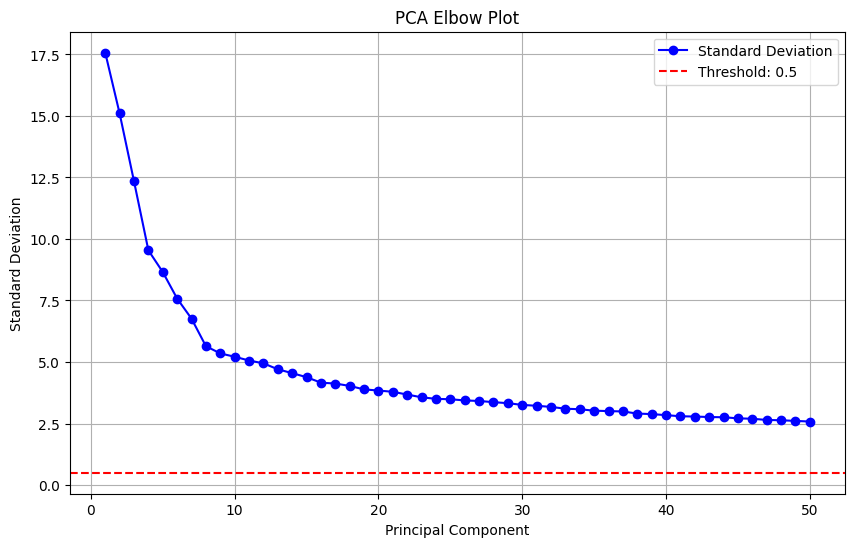

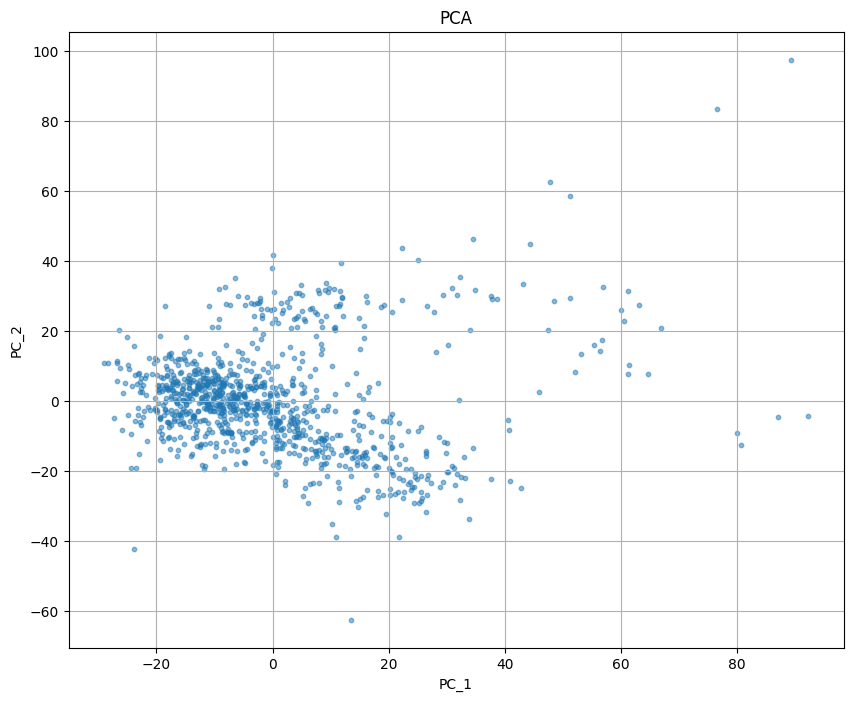

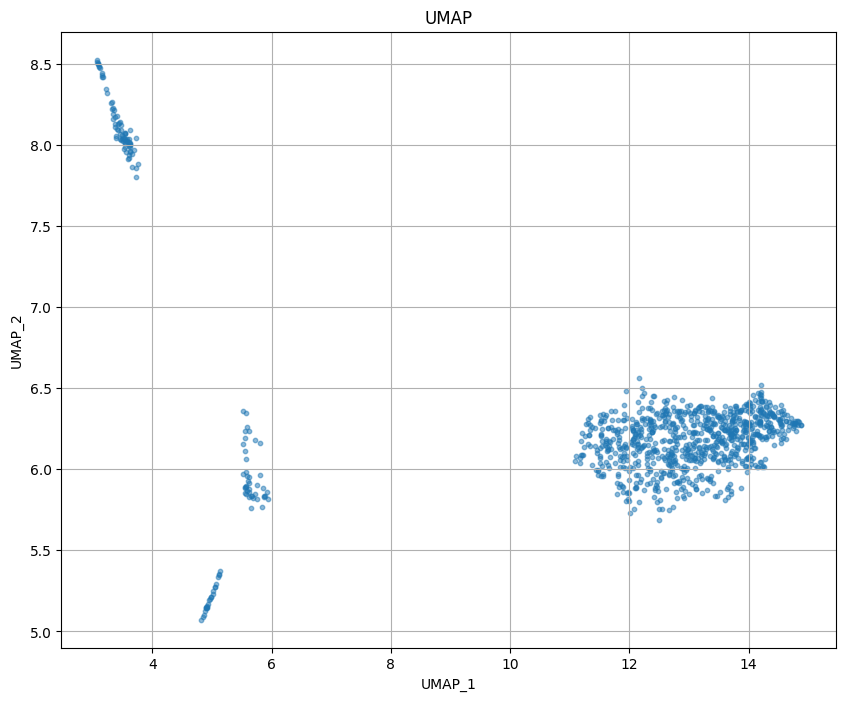

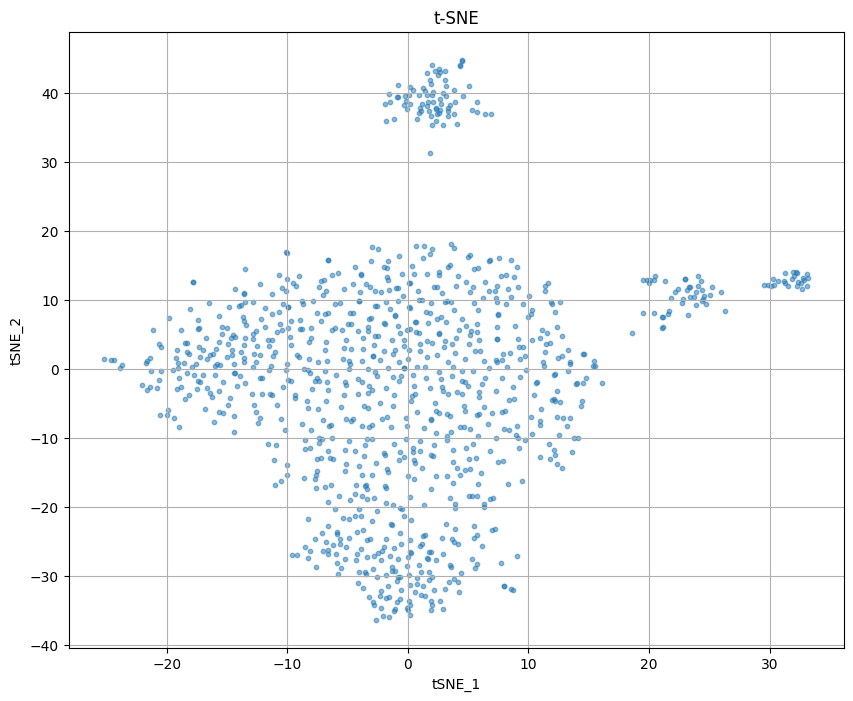

In [92]:
# Visualization
reload(dim_reduction)
# elbow plot
dim_reduction.elbow_plot(pca_object)
# visualization
dim_reduction.visualize_dim_reduction(pca_matrix.iloc[:, :2], 'PCA')
dim_reduction.visualize_dim_reduction(umap_matrix.iloc[:, :2], 'UMAP')
dim_reduction.visualize_dim_reduction(tsne_matrix.iloc[:, :2], 't-SNE')


In [20]:
# Clustering
reload(clustering)
print("\tGraph based") 
clustering1 = clustering.graph_based_clustering_leiden(pca_matrix)
print(clustering1.head())

	Graph based


ValueError: Length of values (997) does not match length of index (999)

In [ ]:
print("\tDensity based")
clustering2 = clustering.density_based_clustering(pca_matrix)
print(clustering2.head())

In [ ]:
reload(clustering)
print("\tDistance based")
clustering3 = clustering.distance_based_clustering(pca_matrix, n_clusters=11)
print(clustering3.head())

In [ ]:
reload(clustering)
print("\tHierarchical")
clustering4 = clustering.hierarchical_clustering(pca_matrix, n_clusters=11)
print(clustering4.head())

In [ ]:
reload(clustering)
print("\tDeep Learning")
clustering5 = clustering.deep_learning_clustering(pca_matrix, n_clusters=11)
print(clustering5.head())

In [ ]:
reload(clustering)
print("\tAffinity propagation")
clustering6 = clustering.affinity_propagation_clustering(pca_matrix)
print(clustering6.head())

In [ ]:
reload(clustering)
print("\tMixture model")
clustering7 = clustering.mixture_model_clustering(pca_matrix, n_components=11)
print(clustering7.head())

In [ ]:
reload(clustering)
print("\tEnsemble")
clustering8 = clustering.ensemble_clustering(pca_matrix, n_clusters=11)
print(clustering8.head())

In [45]:
print(len(set(clustering4)))

10


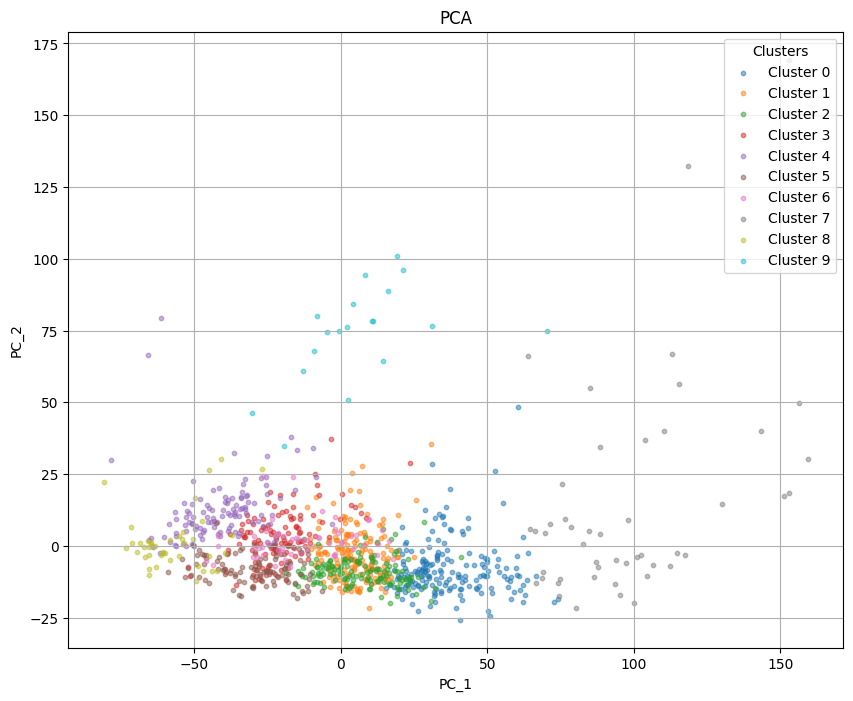

In [16]:
# Clustering visualization
reload(clustering)
clustering.visualize_clusters(pca_matrix, 'PCA', clustering1)

	Expression profile
<class 'pandas.core.frame.DataFrame'>
Index: 32643 entries, MIR1302-10 to ZNF84
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CD14+ Monocyte                32643 non-null  float64
 1   CD19+ B                       32643 non-null  float64
 2   CD34+                         32643 non-null  float64
 3   CD4+ T Helper2                32643 non-null  float64
 4   CD4+/CD25 T Reg               32643 non-null  float64
 5   CD4+/CD45RA+/CD25- Naive T    32643 non-null  float64
 6   CD4+/CD45RO+ Memory           32643 non-null  float64
 7   CD56+ NK                      32643 non-null  float64
 8   CD8+ Cytotoxic T              32643 non-null  float64
 9   CD8+/CD45RA+ Naive Cytotoxic  32643 non-null  float64
 10  Dendritic                     32643 non-null  float64
dtypes: float64(11)
memory usage: 3.0+ MB
None
celltype      CD14+ Monocyte  CD19+ B  CD34+  CD4+ T 

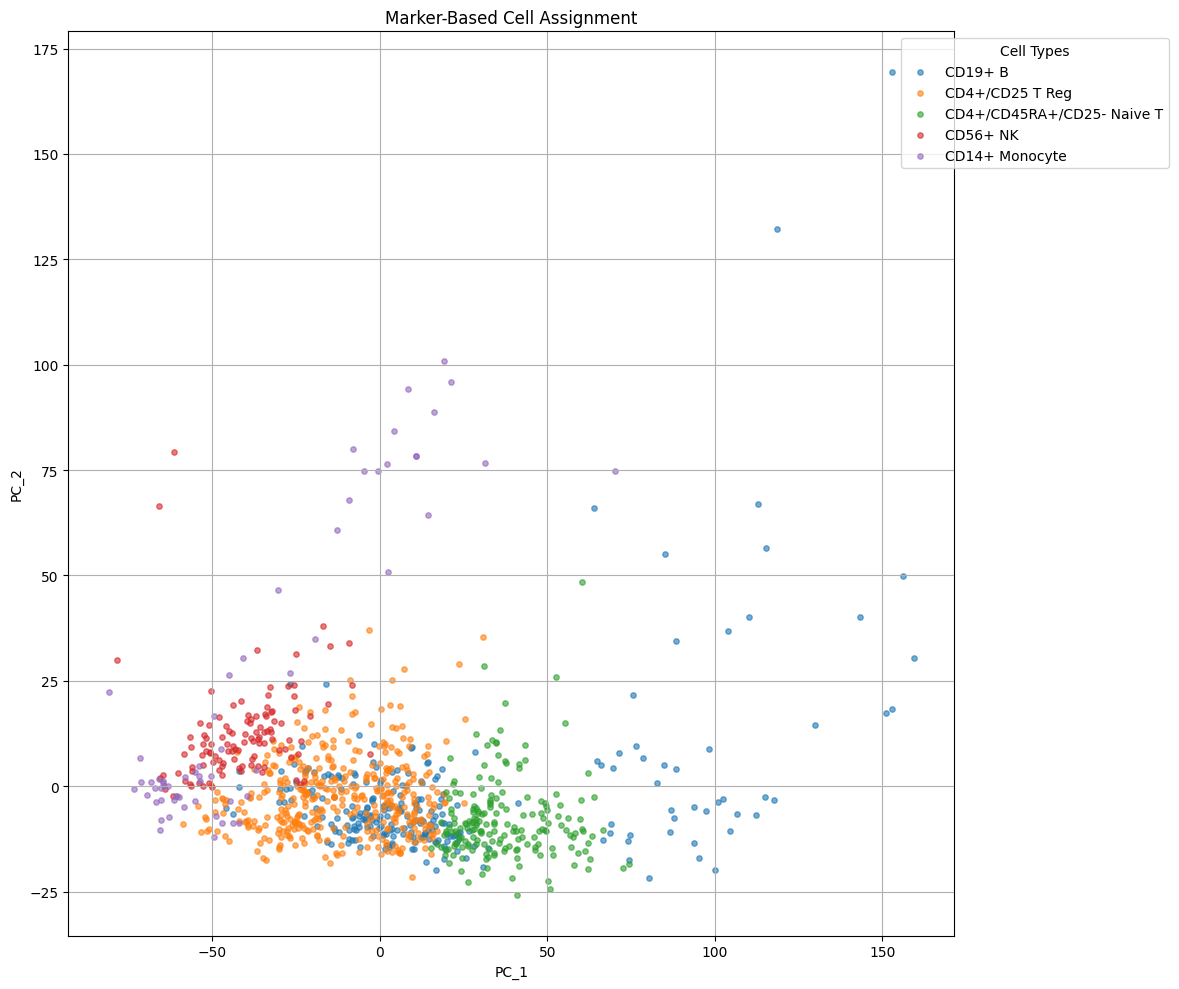

In [17]:
# Cell identification
reload(cell_identification)

print("\tExpression profile")
expression_profile = cell_identification.generate_expression_profiles(expression_matrix, metadata_path, celltype_column='celltype', sep='\t')
print(expression_profile.info())
print(expression_profile.head())

print("\tMarker reference")
marker_genes = cell_identification.generate_marker_reference(expression_matrix, metadata_path, celltype_column='celltype', sep='\t')
print(list(marker_genes.items())[:5])

print("\tReference based")
cell_id_1 = cell_identification.reference_based_assignment(selected_matrix1, clustering1, expression_profile)
print(cell_id_1.head(10))

print("\tCorrelation based")
cell_id_2 = cell_identification.correlation_based_assignment(selected_matrix1, clustering1, expression_profile)
print(cell_id_2.head(10))

print("\tMarker based")
cell_id_3 = cell_identification.marker_based_assignment(selected_matrix1, clustering1, marker_genes)
print(cell_id_3.head(10))

cell_identification.visualize_cells(pca_matrix, "Marker-Based Cell Assignment", cell_id_3)

In [18]:
# Evaluation metrics
reload(evaluation)
print("\tInternal evaluation")
internal_results = evaluation.internal_evaluation(pca_matrix, cell_id_1)
print(internal_results)

print("\tExternal evaluation")
external_results = evaluation.external_evaluation(cell_id_1, true_labels)
print(external_results)

	Internal evaluation
{'Silhouette_Score': 0.09343553372885167, 'ARI': 0.8299297353452566, 'NMI': 0.9315368757451317, 'V_measure': 0.9315368757451317}
	External evaluation
{'Accuracy': 0.413, 'Precision': 0.5207500526049246, 'Recall': 0.413, 'F1_score': 0.44865898791408926}


In [19]:
# Save results
import os
def save_results(pipeline_id, cell_identification_results, internal_metrics,
                 external_metrics, reduced_matrix, tissue):
    """
        Save the results of the pipeline including clustering, cell identification, and metrics.

        Parameters:
        -----------
        pipeline_id : str
            Unique identifier for the pipeline configuration.
        cell_identification_results : pd.DataFrame
            DataFrame containing 'barcode', 'cluster', and 'celltype' columns.
        internal_metrics : dict
            Dictionary containing internal evaluation metrics such as ARI, Silhouette, etc.
        external_metrics : dict
            Dictionary containing external evaluation metrics such as Accuracy, Precision, etc.
        reduced_matrix : pd.DataFrame
            Reduced dimensionality matrix (cells x dimensions).
        tissue : str
            Name of the tissue analyzed (e.g. PBMC).
        """
    # Create the results folder for the tissue if it doesn't exist
    tissue_results_path = f'results/{tissue}_results'
    os.makedirs(tissue_results_path, exist_ok=True)

    # Create the reduced matrix folder for the tissue if it doesn't exist
    tissue_reduced_matrix_path = f'{tissue_results_path}/{tissue}_reduced_matrix'
    os.makedirs(tissue_reduced_matrix_path, exist_ok=True)

    # Create a new row with the results of the pipeline
    result_row = {
        'pipeline_id': pipeline_id,  # Unique identifier for the pipeline
        'barcodes': ','.join(cell_identification_results['barcode'].tolist()),  # Convert the barcode list to a comma-separated string
        'clusters': ','.join(map(str, cell_identification_results['cluster'].tolist())),  # Convert clusters to string
        'cell_types': ','.join(cell_identification_results['celltype'].tolist()),  # Convert cell types to string
        'ARI': internal_metrics['ARI'],
        'Silhouette_Score': internal_metrics['Silhouette_Score'],
        'NMI': internal_metrics['NMI'],
        'V_measure': internal_metrics['V_measure'],
        'Accuracy': external_metrics['Accuracy'],
        'Precision': external_metrics['Precision'],
        'Recall': external_metrics['Recall'],
        'F1_score': external_metrics['F1_score']
    }

    # Save the results to a CSV file
    results_df = pd.DataFrame([result_row])

    # Check if the file already exists
    results_file_path = f'{tissue_results_path}/{tissue}_all_results.csv'
    if not os.path.exists(results_file_path):
        # If it doesn't exist, create it with headers
        results_df.to_csv(results_file_path, index=False, mode='w', header=True)
    else:
        # If it exists, append the new row without headers
        results_df.to_csv(results_file_path, index=False, mode='a', header=False)

    # Save the reduced dimensionality matrix in compressed format (CSV gzip) in the tissue-specific folder
    reduced_matrix_file_path = f'{tissue_reduced_matrix_path}/{pipeline_id}_matrix.csv.gz'
    reduced_matrix.to_csv(reduced_matrix_file_path, index=False, compression='gzip')

    print(f"Results for pipeline {pipeline_id} saved successfully.")

print("\tSave results")
pipeline_id = 'pipeline_1'
save_results(pipeline_id, cell_id_1, internal_results,
                 external_results, pca_matrix, 'PBMC')

	Save results
Results for pipeline pipeline_1 saved successfully.


In [34]:
# Execute step
def execute_step(step_name, methods_dict, method_name, data, extra_params=None):
    """
    Execute a specific step using the provided method.

    Parameters:
    -----------
    step_name : str
        The name of the pipeline step (e.g., 'data_cleaning', 'normalization', etc.).
    methods_dict : dict
        Dictionary containing methods for the current step.
    method_name : str
        The name of the method to be executed.
    data : pd.DataFrame
        The data to be processed by the method.
    extra_params : dict, optional
        Additional parameters required by the method (e.g., file paths, metadata).

    Returns:
    --------
    result : pd.DataFrame or pd.Series
        The result of the executed method.
    """
    method_entry = methods_dict[method_name]
    # Check if the dictionary contains a direct function or a sub-dictionary
    if callable(method_entry):  # Direct function
        method_func = method_entry
    else:  # Sub-dictionary with 'func' and 'params'
        method_func = method_entry['func']
        
    print(f"Running {step_name} - {method_name}")
    
    if extra_params:
        result = method_func(data, **extra_params) # If the function needs extra_params, call it with them
    else:
        result = method_func(data)  # Else, no extra_params is needed
    print(f"Execution of {step_name} - {method_name} done")
    return result

# Dictionary
data_cleaning_methods = {
    'FLEG': data_cleaning.filter_lowly_expressed_genes,
    'FHMC': data_cleaning.filter_high_mitochondrial_content,
    'FD': data_cleaning.filter_doublets_cxds,
    'CC': data_cleaning.combined_cleaning,
}

clustering_methods = {
    'GBC': {'func': clustering.graph_based_clustering_leiden, 'params': {'resolution': 1}},
    'DeBC': {'func': clustering.density_based_clustering, 'params': {'eps': 0.5, 'min_samples': 5}},
    'DiBC': {'func': clustering.distance_based_clustering, 'params': {'n_clusters': 10}},
    'HC': {'func': clustering.hierarchical_clustering, 'params': {'n_clusters': 5}},
    'DLC': {'func': clustering.deep_learning_clustering, 'params': {'n_clusters': 10, 'encoding_dim': 32}},
    'APC': {'func': clustering.affinity_propagation_clustering, 'params': None},
    'MMC': {'func': clustering.mixture_model_clustering, 'params': {'n_components': 10}},  # n_components is n_clusters
    'EC': {'func': clustering.ensemble_clustering, 'params': {'n_clusters': 11, 'eps': 0.5, 'min_samples': 5}},
}

for cluster_method, cluster_config in clustering_methods.items():
    result_step = execute_step('Clustering', clustering_methods, cluster_method, pca_matrix, cluster_config.get('params'))
    print(result_step.info())


Running Clustering - GBC
Execution of Clustering - GBC done
<class 'pandas.core.series.Series'>
Index: 1000 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCCCT-8
Series name: None
Non-Null Count  Dtype
--------------  -----
1000 non-null   int32
dtypes: int32(1)
memory usage: 44.0+ KB
None
Running Clustering - DeBC
Execution of Clustering - DeBC done
<class 'pandas.core.series.Series'>
Index: 1000 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCCCT-8
Series name: None
Non-Null Count  Dtype
--------------  -----
1000 non-null   int64
dtypes: int64(1)
memory usage: 47.9+ KB
None
Running Clustering - DiBC
Execution of Clustering - DiBC done
<class 'pandas.core.series.Series'>
Index: 1000 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCCCT-8
Series name: None
Non-Null Count  Dtype
--------------  -----
1000 non-null   int32
dtypes: int32(1)
memory usage: 44.0+ KB
None
Running Clustering - HC
Execution of Clustering - HC done
<class 'pandas.core.series.Series'>
Index: 1000 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCC

In [41]:
# Main pipeline
import pandas as pd
import scipy.io
import numpy as np
import scipy.sparse
import os
import src.preprocessing.data_cleaning as data_cleaning
import src.preprocessing.normalization as normalization
import src.preprocessing.feature_selection as feature_selection
import src.preprocessing.dim_reduction as dim_reduction
import src.analysis.clustering as clustering
import src.analysis.cell_identification as cell_identification
import src.evaluation.evaluation as evaluation

def load_expression_data_from_mtx(path, barcodes_labeled=None, n_sample=None, random_state=None):
    """
    Load gene expression data from MTX format into a sparse DataFrame.

    Parameters:
    - path: str, path to the folder with the matrix, genes and barcodes.

    Returns:
    - expression_matrix: Sparse DataFrame containing gene expression data.
    """
    # Load expression matrix
    matrix = scipy.io.mmread(path+"matrix.mtx").tocsc()

    # Load genes
    genes = pd.read_csv(path+"genes.tsv", header=None, sep='\t', names=['gene_id', 'gene_symbol'])

    # Load barcodes
    barcodes = pd.read_csv(path+"barcodes.tsv", header=None, sep='\t', names=['barcode'])

    # Filter by labeled barcodes if barcodes_labeled is provided
    if barcodes_labeled is not None:
        if 'barcode' not in barcodes_labeled.columns:
            raise ValueError("The provided barcodes_labeled DataFrame must contain a 'barcode' column.")
        # Find the intersection of barcodes
        labeled_barcodes = set(barcodes_labeled['barcode'])
        matching_indices = barcodes['barcode'].isin(labeled_barcodes)
        matrix = matrix[:, matching_indices]
        barcodes = barcodes[matching_indices]

    # Apply random sampling to barcodes if n_sample is specified
    if n_sample is not None and n_sample < len(barcodes):
        np.random.seed(random_state)
        sampled_indices = np.random.choice(len(barcodes), size=n_sample, replace=False)
        matrix = matrix[:, sampled_indices]  # Subset columns (barcodes)
        barcodes = barcodes.iloc[sampled_indices]

    # Transform sparse matrix into pandas sparse DataFrame
    expression_matrix = pd.DataFrame.sparse.from_spmatrix(matrix)
    expression_matrix.index = genes['gene_symbol']
    expression_matrix.columns = barcodes['barcode']

    expression_matrix = data_cleaning.remove_duplicated_genes(expression_matrix)

    return expression_matrix


def save_results(results_path, pipeline_id, cell_identification_results, internal_metrics,
                 external_metrics, reduced_matrix, tissue):
    """
        Save the results of the pipeline including clustering, cell identification, and metrics.

        Parameters:
        -----------
        results_path : str
            Folder to save the results in.
        pipeline_id : str
            Unique identifier for the pipeline configuration.
        cell_identification_results : pd.DataFrame
            DataFrame containing 'barcode', 'cluster', and 'celltype' columns.
        internal_metrics : dict
            Dictionary containing internal evaluation metrics such as ARI, Silhouette, etc.
        external_metrics : dict
            Dictionary containing external evaluation metrics such as Accuracy, Precision, etc.
        reduced_matrix : pd.DataFrame
            Reduced dimensionality matrix (cells x dimensions).
        tissue : str
            Name of the tissue analyzed (e.g. PBMC).
        """
    # Create the results folder for the tissue if it doesn't exist
    tissue_results_path = f'{results_path}/{tissue}_results'
    os.makedirs(tissue_results_path, exist_ok=True)

    # Create the reduced matrix folder for the tissue if it doesn't exist
    tissue_reduced_matrix_path = f'{tissue_results_path}/{tissue}_reduced_matrix'
    os.makedirs(tissue_reduced_matrix_path, exist_ok=True)

    # Create a new row with the results of the pipeline
    result_row = {
        'pipeline_id': pipeline_id,  # Unique identifier for the pipeline
        'barcodes': ','.join(cell_identification_results['barcode'].tolist()),  # Convert the barcode list to a comma-separated string
        'clusters': ','.join(map(str, cell_identification_results['cluster'].tolist())),  # Convert clusters to string
        'cell_types': ','.join(cell_identification_results['celltype'].tolist()),  # Convert cell types to string
        'ARI': internal_metrics['ARI'],
        'Silhouette_Score': internal_metrics['Silhouette_Score'],
        'NMI': internal_metrics['NMI'],
        'V_measure': internal_metrics['V_measure'],
        'Accuracy': external_metrics['Accuracy'],
        'Precision': external_metrics['Precision'],
        'Recall': external_metrics['Recall'],
        'F1_score': external_metrics['F1_score']
    }

    # Save the results to a CSV file
    results_df = pd.DataFrame([result_row])

    # Check if the file already exists
    results_file_path = f'{tissue_results_path}/{tissue}_all_results.csv'
    if not os.path.exists(results_file_path):
        # If it doesn't exist, create it with headers
        results_df.to_csv(results_file_path, index=False, mode='w', header=True)
    else:
        # If it exists, append the new row without headers
        results_df.to_csv(results_file_path, index=False, mode='a', header=False)

    # Save the reduced dimensionality matrix in compressed format (CSV gzip) in the tissue-specific folder
    reduced_matrix_file_path = f'{tissue_reduced_matrix_path}/{pipeline_id}_matrix.csv.gz'
    reduced_matrix.to_csv(reduced_matrix_file_path, index=False, compression='gzip')

    print(f"Results for pipeline {pipeline_id} saved successfully.")


def generate_pipeline_id(methods_list):
    """
    Generate a unique pipeline ID based on the methods used.

    Parameters:
    -----------
    methods_list : list of str
        List of method names used in the pipeline.

    Returns:
    --------
    pipeline_id : str
        Unique pipeline identifier.
    """
    return "_".join(methods_list)


def execute_step(step_name, methods_dict, method_name, data, extra_params=None):
    """
    Execute a specific step using the provided method.

    Parameters:
    -----------
    step_name : str
        The name of the pipeline step (e.g., 'data_cleaning', 'normalization', etc.).
    methods_dict : dict
        Dictionary containing methods for the current step.
    method_name : str
        The name of the method to be executed.
    data : pd.DataFrame
        The data to be processed by the method.
    extra_params : dict, optional
        Additional parameters required by the method (e.g., file paths, metadata).

    Returns:
    --------
    result : pd.DataFrame or pd.Series
        The result of the executed method.
    """
    method_entry = methods_dict[method_name]
    # Check if the dictionary contains a direct function or a sub-dictionary
    if callable(method_entry):  # Direct function
        method_func = method_entry
    else:  # Sub-dictionary with 'func' and 'params'
        method_func = method_entry['func']
        
    print(f"Running {step_name} - {method_name}")
    
    if extra_params:
        result = method_func(data, **extra_params) # If the function needs extra_params, call it with them
    else:
        result = method_func(data)  # Else, no extra_params is needed
    print(f"Execution of {step_name} - {method_name} done")
    return result


# Dictionaries to execute methods in pipeline
data_cleaning_methods = {
    'FLEG': data_cleaning.filter_lowly_expressed_genes,
    'FHMC': data_cleaning.filter_high_mitochondrial_content,
    'FD': data_cleaning.filter_doublets_cxds,
    'CC': data_cleaning.combined_cleaning,
}

normalization_methods = {
    "CPM": normalization.normalize_cpm,
    "QR": normalization.normalize_quantile_regression,
    "NB": normalization.normalize_negative_binomial,
}

feature_selection_methods = {
    'SHVG': feature_selection.select_highly_variable_genes,
    'SGbV': feature_selection.select_genes_by_variance,
}

dim_reduction_methods = {
    'PCA': dim_reduction.apply_pca,
    'UMAP': dim_reduction.apply_umap,
    'TSNE': dim_reduction.apply_tsne,
}

# TO DO: adjust params
clustering_methods = {
    'GBC': {'func': clustering.graph_based_clustering_leiden, 'params': {'resolution': 1}},
    'DeBC': {'func': clustering.density_based_clustering, 'params': {'eps': 0.5, 'min_samples': 5}},
    'DiBC': {'func': clustering.distance_based_clustering, 'params': {'n_clusters': 11}},
    'HC': {'func': clustering.hierarchical_clustering, 'params': {'n_clusters': 11}},
    'DLC': {'func': clustering.deep_learning_clustering, 'params': {'n_clusters': 11, 'encoding_dim': 32}},
    'APC': {'func': clustering.affinity_propagation_clustering, 'params': None},
    'MMC': {'func': clustering.mixture_model_clustering, 'params': {'n_components': 11}},  # n_components is n_clusters
    'EC': {'func': clustering.ensemble_clustering, 'params': {'n_clusters': 11, 'eps': 0.5, 'min_samples': 5}},
}

cell_identification_methods = {
    'RBA': cell_identification.reference_based_assignment,
    'CBA': cell_identification.correlation_based_assignment,
    'MBA': cell_identification.marker_based_assignment,
}



### Main Pipeline ###
# Change params of dictionaries if needed
tissue = 'PBMC'
metadata_path = "./data/PBMC/PBMC_68k/hg19/68k_pbmc_barcodes_annotation.tsv"
results_path = "./results"

celltype_column = 'celltype'
true_labels = evaluation.load_true_labels(metadata_path, 'barcodes', celltype_column, "\t")

expression_matrix = load_expression_data_from_mtx("./data/PBMC/PBMC_68k/hg19/", barcodes_labeled=true_labels, n_sample=2000, random_state=6)

print(expression_matrix.info())

for cleaning_method in data_cleaning_methods.keys():
    cleaned_matrix = execute_step('data_cleaning', data_cleaning_methods, cleaning_method, expression_matrix)

    for norm_method in normalization_methods.keys():
        normalized_matrix = execute_step('normalization', normalization_methods, norm_method, cleaned_matrix)

        for fs_method in feature_selection_methods.keys():
            selected_matrix = execute_step('feature_selection', feature_selection_methods, fs_method, normalized_matrix)

            for dr_method in dim_reduction_methods.keys():
                # If tSNE, execute with predefined 2 dimensions
                if dr_method == 'TSNE':
                    reduced_matrix = execute_step('dim_reduction', dim_reduction_methods, dr_method,
                                 selected_matrix)
                else:  # PCA or UMAP
                    # Execute PCA
                    pca_object, reduced_matrix = execute_step('dim_reduction', dim_reduction_methods, 'PCA',
                                                            selected_matrix)
                    # If dr_method == PCA, continue, this step is already done
                    # else, if dr_method == UMAP, execute umap with the same number of dimensions as PCA
                    if dr_method == 'UMAP':
                        optimal_num_dimensions = reduced_matrix.shape[1]  # Get the number of components (columns)
                        reduced_matrix = execute_step('dim_reduction', dim_reduction_methods, dr_method,
                                                    selected_matrix, optimal_num_dimensions)

                for cluster_method, cluster_config in clustering_methods.items():
                    clustering_results = execute_step('clustering', clustering_methods, cluster_method, reduced_matrix,
                                                      cluster_config['params'])

                    for cell_id_method in cell_identification_methods.keys():
                        # For marker_based_assignment, marker reference is needed
                        if cell_id_method == 'MBA':
                            reference = cell_identification.generate_marker_reference(expression_matrix, metadata_path, celltype_column=celltype_column, sep='\t')
                            key = 'marker_reference'
                        # For the other 2 methods, expression_profile is needed
                        else:
                            reference = cell_identification.generate_expression_profiles(expression_matrix, metadata_path, celltype_column=celltype_column, sep='\t')
                            key = 'expression_profile'

                        extra_params = {'cluster_results': clustering_results, key: reference}

                        cell_identification_results = execute_step(
                            'cell_identification', cell_identification_methods, cell_id_method, selected_matrix, extra_params
                        )

                        # Internal Evaluation
                        internal_metrics = evaluation.internal_evaluation(reduced_matrix, cell_identification_results)

                        # External Evaluation
                        external_metrics = evaluation.external_evaluation(cell_identification_results, true_labels)

                        # Generate unique pipeline identifier
                        pipeline_id = generate_pipeline_id([
                            cleaning_method, norm_method, fs_method, dr_method, cluster_method, cell_id_method
                        ])

                        # Save results
                        save_results(
                            results_path=results_path,
                            pipeline_id=pipeline_id,
                            cell_identification_results=cell_identification_results,
                            internal_metrics=internal_metrics,
                            external_metrics=external_metrics,
                            reduced_matrix=reduced_matrix,
                            tissue=tissue
                        )

print("Finish!")

<class 'pandas.core.frame.DataFrame'>
Index: 32643 entries, MIR1302-10 to ZNF84
Columns: 2000 entries, CACTTATGTGTCCC-4 to AAGCCATGGTCGTA-4
dtypes: Sparse[float64, 0](2000)
memory usage: 12.6+ MB
None
Running data_cleaning - FLEG
Execution of data_cleaning - FLEG done
Running normalization - CPM
Execution of normalization - CPM done
Running feature_selection - SHVG
Execution of feature_selection - SHVG done
Running dim_reduction - PCA
Execution of dim_reduction - PCA done
Running clustering - GBC
Execution of clustering - GBC done
Running cell_identification - RBA
Execution of cell_identification - RBA done
Results for pipeline FLEG_CPM_SHVG_PCA_GBC_RBA saved successfully.
Running cell_identification - CBA
Execution of cell_identification - CBA done
Results for pipeline FLEG_CPM_SHVG_PCA_GBC_CBA saved successfully.
Running cell_identification - MBA
Execution of cell_identification - MBA done
Results for pipeline FLEG_CPM_SHVG_PCA_GBC_MBA saved successfully.
Running clustering - DeBC
Ex

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
import os
import pandas as pd
from scipy.io import mmread, mmwrite
from scipy.sparse import csr_matrix

# Directorio con las carpetas
base_dir = "./data/Tumor" 
folders = ["CID3586", "CID3838", "CID3921", "CID3941", "CID3946", "CID3948", 
           "CID3963", "CID4040", "CID4066", "CID4465", "CID4495", "CID44041"]

# Inicialización de estructuras combinadas
combined_metadata = pd.DataFrame()
gene_index = set()
matrices = []

# Recorrer todas las carpetas
for folder in folders:
    folder_path = os.path.join(base_dir, folder)

    # Leer la matriz dispersa
    matrix_path = os.path.join(folder_path, "count_matrix_sparse.mtx")
    sparse_matrix = mmread(matrix_path).tocsr()

    # Leer el metadata.csv
    metadata_path = os.path.join(folder_path, "metadata.csv")
    metadata = pd.read_csv(metadata_path)

    # Seleccionar solo las columnas necesarias
    metadata = metadata.iloc[:, [0]].join(metadata[["celltype_minor"]])

    # Agregar los barcodes como índices de la metadata
    barcodes = metadata.iloc[:, 0].values
    if sparse_matrix.shape[1] != len(barcodes):
        raise ValueError(f"El número de columnas en {matrix_path} no coincide con los barcodes en {metadata_path}")

    # Actualizar el índice maestro de genes
    genes_path = os.path.join(folder_path, "count_matrix_genes.tsv")  # Asegúrate de que exista un archivo con los nombres de genes
    genes = pd.read_csv(genes_path, sep='\t', header=None)[0].tolist()
    gene_index.update(genes)

    # Guardar la matriz y los barcodes para reindexar más adelante
    matrices.append((sparse_matrix, genes, barcodes))

    # Actualizar la metadata combinada
    combined_metadata = pd.concat([combined_metadata, metadata], ignore_index=True)

# Crear índice maestro ordenado de genes
gene_index = sorted(gene_index)
gene_to_idx = {gene: idx for idx, gene in enumerate(gene_index)}

# Inicializar la matriz combinada
total_cells = sum(mat[0].shape[1] for mat in matrices)
combined_matrix = csr_matrix((len(gene_index), total_cells), dtype=float)

# Rellenar la matriz combinada
current_col = 0
for sparse_matrix, genes, barcodes in matrices:
    gene_positions = [gene_to_idx[gene] for gene in genes]
    for col in range(sparse_matrix.shape[1]):
        combined_matrix[gene_positions, current_col] = sparse_matrix[:, col].toarray().flatten()
        current_col += 1

# Guardar los resultados combinados
mmwrite("./data/Tumor/combined_count_matrix.mtx", combined_matrix)
combined_metadata.to_csv("./data/Tumor/combined_metadata.csv", index=False)

print("Combinación completada y archivos guardados.")

c:\users\34659\pycharmprojects\master_thesis\scrnaseq_across_human_tissues\myenv\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
import pandas as pd
import scipy.sparse
import joblib

# Ruta al archivo CSV
csv_path = "../data/Neuronal/M1/matrix.csv"

def read_and_process_csv_in_chunks(csv_path, chunk_size=10000, output_file='../data/Neuronal/M1/sparse_dataframe.joblib'):
    """
    Read a large CSV file in chunks, transpose, convert to sparse, and concatenate.

    Parameters:
    - csv_path: str, path to the CSV file.
    - chunk_size: int, number of rows to read in each chunk.

    Returns:
    - sparse_expression_matrix: Sparse DataFrame containing the full gene expression data.
    """
    # Initialize a list to store processed chunks
    processed_chunks = []
    genes = None
    barcodes = []
    print(f"Empezamos", flush=True)
    
    # Read the CSV in chunks
    for chunk in pd.read_csv(csv_path, sep=',', chunksize=chunk_size,  header=0, index_col=0):
        print(f"Processing chunk rows {chunk.index[0]} to {chunk.index[-1]}...", flush=True)

        # Keep genes
        if genes is None:
            genes = chunk.columns.tolist()
        
        # Keep barcodes
        barcodes.extend(chunk.index.tolist())
        
        # Transpose the chunk so rows are genes and columns are barcodes
        chunk = chunk.T
        
        # Convert to Sparse DataFrame
        sparse_chunk = scipy.sparse.csr_matrix(chunk)
        
        # Add the processed chunk to the list
        processed_chunks.append(sparse_chunk)
        
        # Free memory from the current chunk
        del chunk  # Optional, to ensure the original chunk memory is freed
        
    # Concatenate all processed chunks into a single Sparse DataFrame
    full_sparse_matrix = scipy.sparse.vstack(processed_chunks)
    sparse_expression_matrix = pd.DataFrame.sparse.from_spmatrix(
        full_sparse_matrix,
        index=genes,
        columns=barcodes
    )

    joblib.dump(sparse_expression_matrix, output_file)
    
    # Return the complete Sparse DataFrame
    return sparse_expression_matrix

def load_sparse_dataframe(input_file='../data/Neuronal/M1/sparse_dataframe.joblib'):
    return joblib.load(input_file)


# Read and process the CSV in chunks
sparse_matrix = read_and_process_csv_in_chunks(csv_path)

sparse_dataframe = load_sparse_dataframe('../data/Neuronal/M1/sparse_dataframe.joblib')

# Show column names (First 10)
print("Column Names Matrix (First 10):", sparse_matrix.columns[:10])

# Show head of the Sparse Expression Matrix
print("\nHead of the Sparse Expression Matrix:")
print(sparse_matrix.head())

# Show data types of the Sparse Expression Matrix
print("\nData Types of the Sparse Expression Matrix:")
print(sparse_matrix.dtypes)

# Show shape of the Sparse Expression Matrix
print("\nShape of the Sparse Expression Matrix:", sparse_matrix.shape)

# Mostrar información
print("Dimensiones de la matriz:", sparse_dataframe.shape)
print("\nPrimeros 5 genes:", sparse_dataframe.index[:5])
print("\nPrimeros 5 barcodes:", sparse_dataframe.columns[:5])
print("\nMuestra de la matriz:")
print(sparse_dataframe.iloc[:5, :5])

Empezamos
Processing chunk rows AAACCCAAGGATTTCC-LKTX_190129_01_A01 to ATCGCCTTCACTGGGC-LKTX_190129_01_C01...
Processing chunk rows ATCGCCTTCGAGAAAT-LKTX_190129_01_C01 to CATCCACAGGCCGCTT-LKTX_190129_01_E01...
Processing chunk rows CATCCACCAAATGCGG-LKTX_190129_01_E01 to TTTCGATCACCATTCC-LKTX_190129_01_F01...
Processing chunk rows TTTCGATCATACATCG-LKTX_190129_01_F01 to TCGCTTGGTTTACGTG-LKTX_190130_01_A01...
